In [19]:
import os
import torch
from torch.utils.data import DataLoader
from problems.MCLP.problem_MCLP import MCLP  # Make sure to import from the correct module
from utils import move_to, load_model  # Import the load_model function from utils
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from IPython.display import display, HTML

# Set max-height to 'none' to prevent scrollbar
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [20]:
from docplex.mp.model import Model

### Helper functions

In [21]:
def create_dataset_from_file(file_path):
    # Load parameters from JSON file
    with open(file_path, 'r') as file:
        params = json.load(file)

    # Extract required parameters for make_dataset function
    n_users = params.get('n_users', 500)
    n_facilities = params.get('n_facilities', 150)
    p = params.get('p', 40)
    r = params.get('r', 0.05)

    # Create dataset instance using MCLP.make_dataset
    random_dataset = MCLP.make_dataset(n_users=n_users, n_facilities=n_facilities, num_samples=1, p=p, r=r)

    # Display the dataset instance or process as needed
    print(random_dataset)
    
    return random_dataset


def plot_points(demand_points, demand_vals, candidate_points, selected_idxes, radius, title=None):
    """
    Plot the demand points, candidate points (CLS), and selected coverage circles.

    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param selected_idxes: List of indexes corresponding to the selected candidate points
    :param radius: Radius for the coverage circles
    :param demand_vals: Array of demand values corresponding to each demand point
    """
    if len(demand_points) != len(demand_vals):
        raise ValueError("The length of demand_points and demand_vals must be the same.")

    plt.figure(figsize=(10, 8))

    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)

    # Plot candidate points
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=30, marker='x')

    # Plot selected points and their coverage circles
    for idx in selected_idxes:
        point = candidate_points[idx]
        circle = plt.Circle((point[0], point[1]), radius, color='green', fill=False, linestyle='--',
                            label='Coverage Area' if idx == selected_idxes[0] else "")
        plt.gca().add_patch(circle)
        plt.scatter(point[0], point[1], c='green', label='Selected Points' if idx == selected_idxes[0] else "",
                    s=30, marker='o')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title(
            f"{len(demand_points)} demand units - {len(candidate_points)} CLS - {len(selected_idxes)} selected (r={radius})"
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')
    plt.show()
    
    
def calculate_solution_objective(demand_points, demand_vals, facility_candidate_locations, radius, selected_facility_indexes):
    covered_points = set()  

    for facility_idx in selected_facility_indexes:
        facility = facility_candidate_locations[facility_idx]  

        for i, demand_point in enumerate(demand_points):
            distance = np.linalg.norm(facility - demand_point)  
            if distance <= radius:
                covered_points.add(i)  

    total_demand_covered = sum(demand_vals[i] for i in covered_points)
    # Print the number of covered points
    print(f"Number of covered demand points: {len(covered_points)}")

    return total_demand_covered

## Setup dataset

In [22]:
# Set up the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#random_dataset = MCLP.make_dataset(n_users=500, n_facilities=150, num_samples=1, p=40, r=0.05)

# Generate a random dataset
random_dataset = create_dataset_from_file('outputs/MCLP/500_150_20_20241005T184518/args.json')

# Use DataLoader to load the dataset
random_dataloader = DataLoader(random_dataset, batch_size=1)

# get the first batch
batch = next(iter(random_dataloader))
batch = move_to(batch, device)

demand_pts = batch['users'].squeeze(0).cpu().numpy()  # (n_users, 2)
demand_vals = batch['demand'].squeeze(0).cpu().numpy() 
cls = batch['facilities'].squeeze(0).cpu().numpy()  # (n_facilities, 2)
r = 0.05

## DRL model approach

  [*] Loading model from outputs/MCLP/500_150_20_20241005T184518/epoch-199.pt
objective val: 415.99993896484375
log-likelihood: -34.24845504760742
selected facility indexes: [[27, 26, 10, 116, 19, 55, 21, 84, 20, 56, 49, 60, 122, 98, 140, 37, 75, 136, 24, 29]]
Number of covered demand points: 80
[415.99988]


C:\Users\yzhon\AppData\Local\Temp\ipykernel_39248\4078016083.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


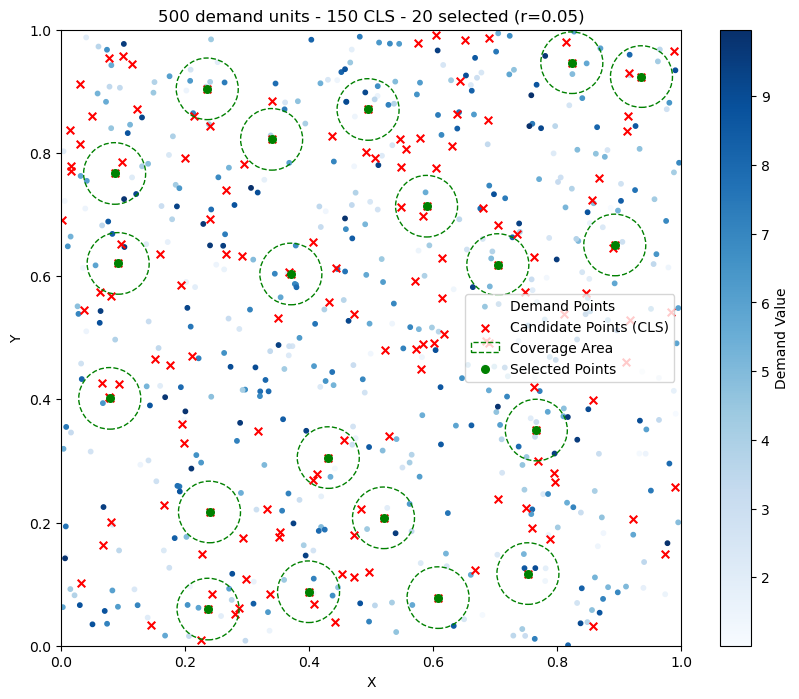

In [23]:
# Load the model using utils.load_model
model_path = 'outputs/MCLP/500_150_20_20241005T184518/epoch-199.pt'  # Adjust this path to your saved model
model, opts = load_model(model_path)  # load_model returns the model and options used during training

model.to(device)  # Move the model to the device (GPU/CPU)
model.eval()  # Set the model to evaluation mode
model.set_decode_type("greedy")
    
with torch.no_grad():
    cost, ll, selected_facilities = model(batch, return_pi=True)
    print("objective val:", -cost.item())
    print("log-likelihood:", ll.item())
    print("selected facility indexes:", selected_facilities.tolist()) 

selected_indices = selected_facilities.squeeze(0).cpu().numpy()  # selected

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, selected_indices)
print(obj_val)

plot_points(demand_pts, demand_vals, cls, selected_indices, r)

## Heuristic - GA approach

In [24]:
from algorithms.GA import GeneticAlgorithm

Current top solution: [59, 50, 79, 47, 145, 31, 80, 106, 69, 2, 75, 146, 147, 19, 142, 96, 70, 57, 28, 107] f=2155

Final top solution: [57, 130, 44, 50, 89, 86, 21, 55, 97, 1, 66, 69, 94, 19, 54, 26, 103, 75, 16, 47] f=1958
Time: 00:00:0.3374
Number of covered demand points: 123
[708.74603]


C:\Users\yzhon\AppData\Local\Temp\ipykernel_39248\4078016083.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


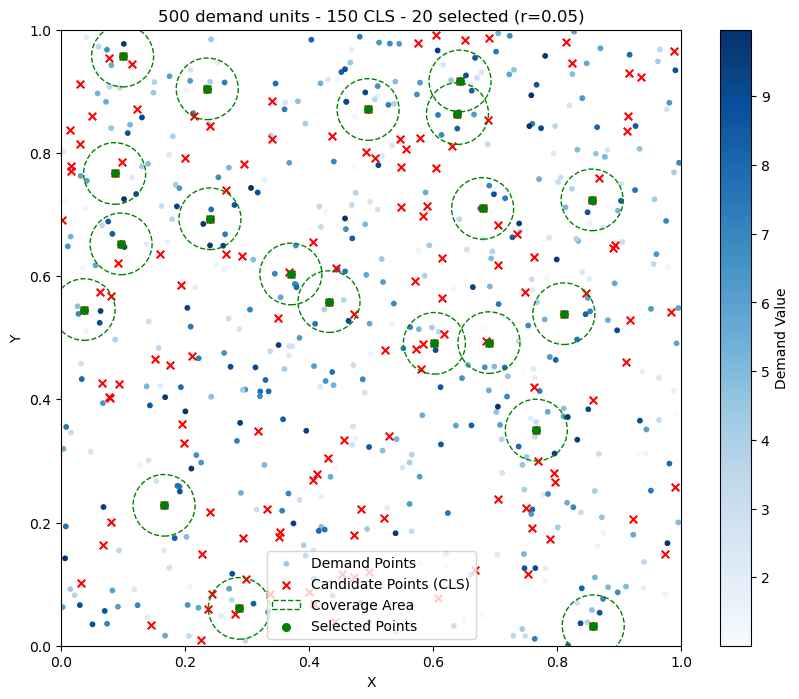

In [28]:
p = 20

# Calculate the distance matrix (Euclidean distance between facilities and demand points)
distance = np.sqrt(np.sum((cls[:, np.newaxis, :] - demand_pts[np.newaxis, :, :]) ** 2, axis=-1))

# Instantiate the genetic algorithm with the necessary parameters
genetic = GeneticAlgorithm(len(demand_pts), len(cls), p, distance, r, demand_vals)

# Run the optimization process
genetic.optimize()

# Get the result (selected centers and the objective value)
obj = np.sum(demand_vals) - genetic.top_chromosome.fitness.item()  # Ensure fitness is a scalar
ga_solution = genetic.top_chromosome.content

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, ga_solution)
print(obj_val)

plot_points(demand_pts, demand_vals, cls, ga_solution, r)

## CPlex solver

In [29]:
def solve_mclp_cplex(demand_pts, demand_vals, facility_candidate_locations, radius, max_num_selection):
    """
    Solves the Maximal Covering Location Problem using CPLEX.
    """
    num_demand_pts = len(demand_pts)
    num_facilities = len(facility_candidate_locations)
    
    # Create a CPLEX model
    mdl = Model(name="MCLP")

    # Decision variables
    x = mdl.binary_var_list(num_facilities, name="x")  # Facility selection variables
    y = mdl.binary_var_list(num_demand_pts, name="y")  # Demand point coverage variables

    # Calculate coverage: which facilities can cover which demand points
    coverage = []
    for i, demand_pt in enumerate(demand_pts):
        facilities_covering_i = []
        for j, facility in enumerate(facility_candidate_locations):
            # Calculate Euclidean distance between demand point and facility
            if np.linalg.norm(np.array(facility) - np.array(demand_pt)) <= radius:
                facilities_covering_i.append(j)
        coverage.append(facilities_covering_i)
    
    # Objective: maximize the total demand covered
    mdl.maximize(mdl.sum(demand_vals[i].item() * y[i] for i in range(num_demand_pts)))

    # Constraints
    # Each demand point i can only be covered if at least one facility that covers it is selected
    for i in range(num_demand_pts):
        mdl.add_constraint(y[i] <= mdl.sum(x[j] for j in coverage[i]))

    # At most max_num_selection facilities can be selected
    mdl.add_constraint(mdl.sum(x[j] for j in range(num_facilities)) <= max_num_selection)

    # Solve the model
    solution = mdl.solve(log_output=True)
    
    if solution:
        print("Objective Value (Total Demand Covered):", solution.objective_value)
        selected_facilities = [j for j in range(num_facilities) if x[j].solution_value > 0.5]
        print("Selected facility indexes:", selected_facilities)
        return selected_facilities
    else:
        print("No solution found.")
        return None

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 3 times.
MIP Presolve eliminated 322 rows and 207 columns.
Aggregator did 103 substitutions.
Reduced MIP has 76 rows, 187 columns, and 350 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.50 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 76 rows, 187 columns, and 350 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.35 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.00 sec. (0.23 ticks)

        Nodes                                         Cuts/
   Node  Left   

C:\Users\yzhon\AppData\Local\Temp\ipykernel_39248\4078016083.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


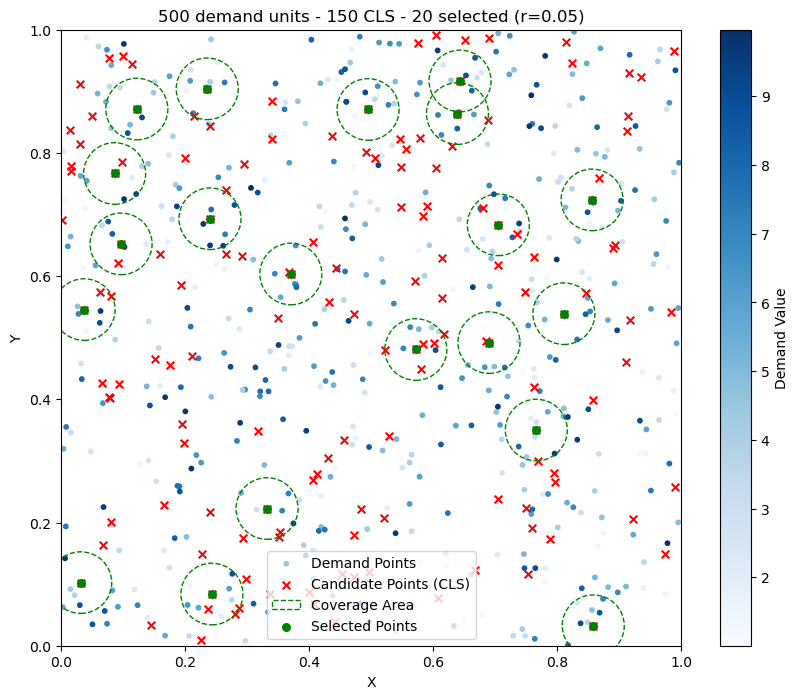

In [31]:
# Solve the problem using the genetic algorithm
max_num_selection = 20
cplex_solution = solve_mclp_cplex(demand_pts, demand_vals, cls, r, max_num_selection)

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, cplex_solution)
print(obj_val)

plot_points(demand_pts, demand_vals, cls, cplex_solution, r)